# Model Comparison

This notebook aims to compare different models and their difference in behavior when predicting certain elements.

In [204]:
import os
import json
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen

## Text Preparation Imports

In [3]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import re
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/asoliman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Neural Networks Imports

In [44]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

# Reading the Dataset

In [7]:
df = pd.read_csv('data/merged_data_equally_sampled_cat_gender.csv')

In [8]:
df = df[df['reviewText'].notnull()]
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def clean_text(text):
    """
        text: a string
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [9]:
df = df.reset_index(drop=True)
df['reviewText'] = df['reviewText'].apply(clean_text)
df['reviewText'] = df['reviewText'].str.replace('\d+', '')

In [10]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 25000
# Max number of words in each review.
MAX_SEQUENCE_LENGTH = 150
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['reviewText'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 449255 unique tokens.


In [85]:
## Source https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [41]:
def draw_cf(cf_matrix):
    group_names = ['True Pos','False Neg','False Pos','True Neg']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [51]:
def prep_for_training(dataframe, target='reviewerGender'):
    X = tokenizer.texts_to_sequences(dataframe['reviewText'].values)
    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
    Y = pd.get_dummies(dataframe[target]).values
    return X,Y

def prep_for_training_without_keywords(dataframe, without, target='reviewerGender'):
    new_tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    new_tokenizer.fit_on_texts(list(without.index))
    X = new_tokenizer.texts_to_sequences(dataframe.review.values)
    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
    Y = pd.get_dummies(dataframe[target]).values
    return X,Y

In [53]:
def split_text(text):
    text = text.split()[:500]
    return text

df['review'] = df.reviewText.apply(clean_text)
df['review'] = df.reviewText.apply(split_text)

In [54]:
def create_idf_dict(series):
    dictionary = dict()
    for bag_of_words in series:
        no_duplicates = list(dict.fromkeys(bag_of_words))
        #print(no_duplicates)
        for word in no_duplicates:
            insert(dictionary, word)
    return dictionary

def insert(dictionary, word):
    if word in dictionary:
        dictionary[word] += 1
    else:
        dictionary[word] = 1

def build_feature_matrix(reviews, f_words):
    fm = list()
    for review in reviews:
        counter = Counter(review)
        fm.append([counter[word] for word in f_words.index])
    fm_df = pd.DataFrame(data=fm, index=reviews.index, columns=f_words.index)
    nwords = reviews.apply(lambda text: len(text))
    fm_df = fm_df.div(nwords, axis=0)
    # for i in range(len(data)):
    #     counter = Counter(data.X.iloc[i])
    #     fm.iloc[i] = [counter[word] for word in f_words]
    fm_df = fm_df * f_words.scores
    return fm_df

def gender_table(df, gender="female"):
    # computes in how many docs word occur (just once per doc) 
    # for clothing:
    
    col_cloth = f"clothing_{gender}"
    X_train = df[(df.reviewerGender == gender) & (df.category == "clothing")]
    count_word_dict_clothing = create_idf_dict(X_train.review)
    idf_scores_clothing = pd.DataFrame.from_dict(count_word_dict_clothing, orient="index")
    idf_scores_clothing.columns = [col_cloth]
    idf_scores_clothing = idf_scores_clothing.sort_values(by=col_cloth, ascending=False)[:50000]
    
    # for electrnoics
    col_elec = f"electronics_{gender}"
    X_train = df[(df.reviewerGender == gender) & (df.category == "electronics")]
    count_word_dict_elec = create_idf_dict(X_train.review)
    idf_scores_elec = pd.DataFrame.from_dict(count_word_dict_elec, orient="index")
    idf_scores_elec.columns = [col_elec]
    idf_scores_elec = idf_scores_elec.sort_values(by=col_elec, ascending=False)[:50000]
    

    # inner join and calculate ratio
    idf_scores = idf_scores_clothing.join(idf_scores_elec, how="inner")
    idf_scores = (idf_scores/len(df))*100000
    idf_scores[f"ratio_{gender}"] = idf_scores[col_cloth] / idf_scores[col_elec]
    #idf_scores[f"ratio_{gender}"] = idf_scores[f"ratio_{gender}"].apply(lambda x: 1/x if x > 1 else x)
    
    return idf_scores

idf_scores_female = gender_table(df, "female")
idf_scores_male = gender_table(df, "male")
idf_scores = idf_scores_female.join(idf_scores_male, how="inner")
idf_scores["diff"] = np.abs(idf_scores.ratio_male - idf_scores.ratio_female)
#idf_scores.sort_values(by="ratio")

In [112]:
MIN_ERROR = 0.9
without_clothing = idf_scores[(idf_scores.ratio_male < (1/MIN_ERROR)) | (idf_scores.ratio_female < (1/MIN_ERROR))]
without_elec = idf_scores[(idf_scores.ratio_male > MIN_ERROR) | (idf_scores.ratio_female > MIN_ERROR)]
without_keywords = idf_scores[(idf_scores.index.isin(without_clothing.index)) & ((idf_scores.index.isin(without_elec.index)))]
without_keywords

clothing_female  electronics_female  ratio_female  clothing_male  \
like           3241.506078         3593.944239      0.901936    3106.568325   
little         2158.191547         2037.128820      1.059428    1736.503256   
im             1761.065802         1868.441003      0.942532    1337.377508   
made           1309.627456         1105.814573      1.184310    1299.127436   
bit            1185.877224          958.251797      1.237542    1056.001980   
...                    ...                 ...           ...            ...   
rubberish         0.062500            0.562501      0.111111       0.312501   
bros              0.062500            0.500001      0.125000       0.812502   
tribe             0.062500            0.187500      0.333333       0.500001   
robbing           0.062500            0.500001      0.125000       0.437501   
terror            0.062500            0.500001      0.125000       0.312501   

           electronics_male  ratio_male      diff  
like            3429.006429    0.905967  0.004032  
little          1920.816102    0.904045  0.155384  
im              1793.753363    0.745575  0.196957  
made            1174.064701    1.106521  0.077789  
bit             1110.877083    0.950602  0.286940  
...                     ...         ...       ...  
rubberish          0.312501    1.000000  0.888889  
bros               0.625001    1.300000  1.175000  
tribe              0.187500    2.666667  2.333333  
robbing            0.250000    1.750000  1.625000  
terror             0.250000    1.250000  1.125000  

[3231 rows x 7 columns]

In [77]:
def get_model_cf(target, model_path='models/keyword-classification', min_error=0.2, without_keywords_flag = False):
    '''
    Get Confusion Matrix for specific Model
    Target can be 'category' or 'reviewerGender'
    '''
    if without_keywords_flag:
        MIN_ERROR = min_error
        without_clothing = idf_scores[(idf_scores.ratio_male < (1/MIN_ERROR)) | (idf_scores.ratio_female < (1/MIN_ERROR))]
        without_elec = idf_scores[(idf_scores.ratio_male > MIN_ERROR) | (idf_scores.ratio_female > MIN_ERROR)]
        without_keywords = idf_scores[(idf_scores.index.isin(without_clothing.index)) & ((idf_scores.index.isin(without_elec.index)))]
        X, Y = prep_for_training_without_keywords(df, without_keywords, target)
    else:    
        X, Y = prep_for_training(df,target)
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 414421)
    model = keras.models.load_model(model_path)
    scores = model.evaluate(X_test, Y_test, verbose=0)
    print("Accuracy of the model: %.2f%%" % (scores[1]*100))
    Y_pred = model.predict(X_test)
    matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))
    return model, matrix

In [93]:
model_category, cf_category = get_model_cf('category','models/keyword-classification')

Accuracy of the model: 91.96%


In [94]:
make_confusion_matrix(cf_category, categories=['clothing','electronics'])

In [95]:
_, cf_category_without_low_error = get_model_cf('category','models/keyword-classification-without-product-keywords-0.2', min_error=0.2, without_keywords_flag=True)

Accuracy of the model: 84.23%


In [96]:
make_confusion_matrix(cf_category_without_low_error, categories=['clothing','electronics'])

In [97]:
_, cf_category_without_med_error = get_model_cf('category','models/keyword-classification-without-product-keywords-0.5', min_error=0.5, without_keywords_flag=True)

Accuracy of the model: 74.34%


In [98]:
make_confusion_matrix(cf_category_without_med_error, categories=['clothing','electronics'])

In [99]:
_, cf_category_without_high_error = get_model_cf('category','models/keyword-classification-without-product-keywords-0.8', min_error=0.8, without_keywords_flag=True)

Accuracy of the model: 62.01%


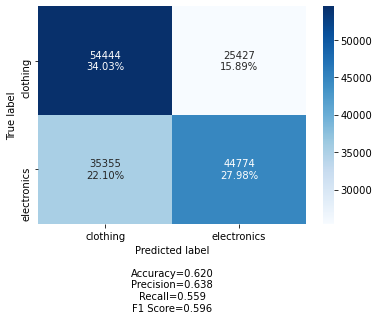

In [100]:
make_confusion_matrix(cf_category_without_high_error, categories=['clothing','electronics'])

In [128]:
_, cf_category_without_09_error = get_model_cf('category','models/keyword-classification-without-product-keywords-0.9', min_error=0.9, without_keywords_flag=True)

Accuracy of the model: 51.40%


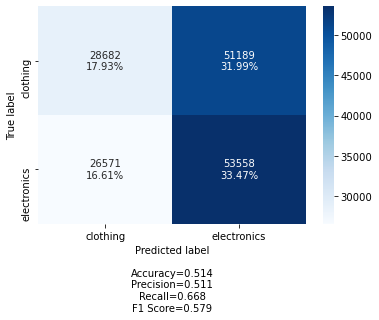

In [129]:
make_confusion_matrix(cf_category_without_09_error, categories=['clothing','electronics'])

In [116]:
_, cf_category_without_maximum_error = get_model_cf('category','models/keyword-classification-without-product-keywords-1', min_error=1, without_keywords_flag=True)

Accuracy of the model: 49.47%


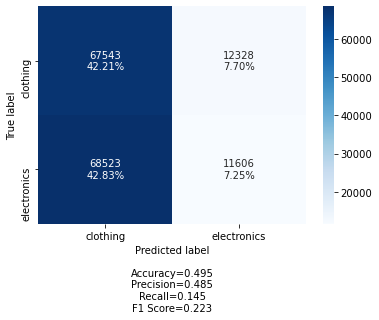

In [117]:
make_confusion_matrix(cf_category_without_maximum_error, categories=['clothing','electronics'])

In [102]:
model_gender, cf_gender = get_model_cf('reviewerGender','models/gender-classification')

Accuracy of the model: 68.76%


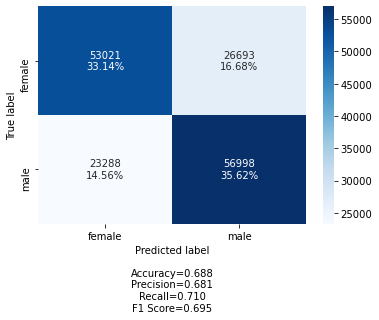

In [103]:
make_confusion_matrix(cf_gender, categories=['female','male'])

In [104]:
_, cf_gender_without_low_error = get_model_cf('reviewerGender','models/gender-classification-without-product-keywords-0.2', min_error=0.2, without_keywords_flag=True)

Accuracy of the model: 65.89%


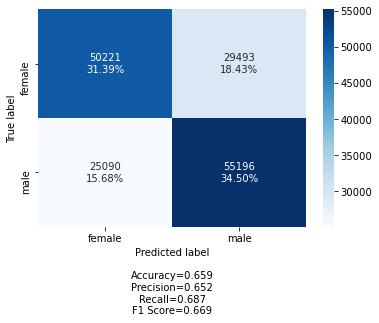

In [110]:
make_confusion_matrix(cf_gender_without_low_error, categories=['female','male'])

In [106]:
_, cf_gender_without_med_error = get_model_cf('reviewerGender','models/gender-classification-without-product-keywords-0.5', min_error=0.5, without_keywords_flag=True)

Accuracy of the model: 63.21%


In [107]:
make_confusion_matrix(cf_gender_without_med_error, categories=['female','male'])

In [108]:
_, cf_gender_without_high_error = get_model_cf('reviewerGender','models/gender-classification-without-product-keywords-0.8', min_error=0.8, without_keywords_flag=True)

Accuracy of the model: 58.07%


In [109]:
make_confusion_matrix(cf_gender_without_high_error, categories=['female','male'])

In [122]:
_, cf_gender_without_09_error = get_model_cf('reviewerGender','models/gender-classification-without-product-keywords-0.9', min_error=0.9, without_keywords_flag=True)

Accuracy of the model: 55.94%


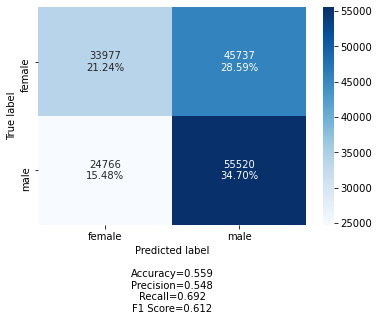

In [123]:
make_confusion_matrix(cf_gender_without_09_error, categories=['female','male'])

In [125]:
_, cf_gender_without_maximum_error = get_model_cf('reviewerGender','models/gender-classification-without-product-keywords-1', min_error=1, without_keywords_flag=True)

Accuracy of the model: 54.81%


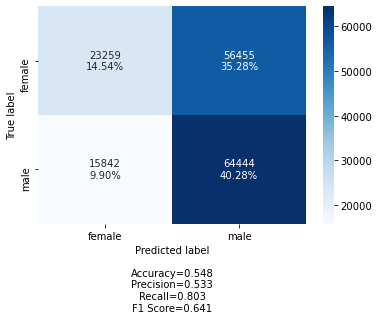

In [126]:
make_confusion_matrix(cf_gender_without_maximum_error, categories=['female','male'])

# Accuracy Comparison


In [171]:
errors = [0, 0.2, 0.5, 0.8, 0.9, 1]
category_cfs = [cf_category, cf_category_without_low_error, cf_category_without_med_error, cf_category_without_high_error,cf_category_without_09_error, cf_category_without_maximum_error]
gender_cfs = [cf_gender, cf_gender_without_low_error, cf_gender_without_med_error, cf_gender_without_high_error,cf_gender_without_09_error, cf_gender_without_maximum_error]

In [232]:
def create_plot_df(cfs, errors):
    plot_df = pd.DataFrame()
    plot_df['error'] = errors
    plot_df['accuracy'] = [np.trace(cf) / float(np.sum(cf)) for cf in cfs]
    plot_df['correctly-female'] = true_positives = [cf.flatten()[0] for cf in cfs]
    plot_df['correctly-male'] = true_negatives = [cf.flatten()[3] for cf in cfs]
    return plot_df

In [233]:
def draw_plots(plot_df):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,4))
    plot_df.plot(x='error', y='accuracy', ylabel='accuracy', ax=ax1).set_ylim([0.4,1])
    plot_df.plot(x='error', y=['correctly-female','correctly-male'], ylabel='counts', ax=ax2)
    plt.show()

In [223]:
plot_df_cat

error  accuracy     tp     tn
0    0.0  0.919562  74609  72521
1    0.2  0.842319  67112  67659
2    0.5  0.743375  57035  61905
3    0.8  0.620112  54444  44774
4    0.9  0.514000  28682  53558
5    1.0  0.494681  67543  11606

(0.4, 1.0)

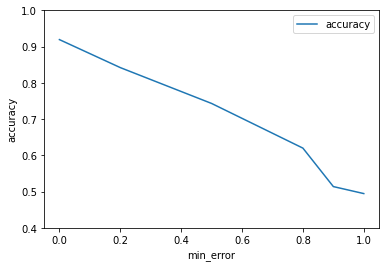

In [234]:
plot_df_cat.plot(x='error', y='accuracy',xlabel='min_error', ylabel='accuracy').set_ylim([0.4,1])

In [235]:
plot_df_gender = create_plot_df(gender_cfs, errors)
draw_plots(plot_df_gender)

In [214]:
_, cf_gender_mixture = get_model_cf('reviewerGender','models/gender-classification-mixture-model')
_, cf_gender_mixture_02_error = get_model_cf('reviewerGender','models/gender-classification-mixture-model-0.2', min_error=0.2, without_keywords_flag=True)
_, cf_gender_mixture_05_error = get_model_cf('reviewerGender','models/gender-classification-mixture-model-0.5', min_error=0.5, without_keywords_flag=True)
_, cf_gender_mixture_08_error = get_model_cf('reviewerGender','models/gender-classification-mixture-model-0.8', min_error=0.8, without_keywords_flag=True)
_, cf_gender_mixture_09_error = get_model_cf('reviewerGender','models/gender-classification-mixture-model-0.9', min_error=0.9, without_keywords_flag=True)
_, cf_gender_mixture_1_error = get_model_cf('reviewerGender','models/gender-classification-mixture-model-1.0', min_error=1.0, without_keywords_flag=True)

Accuracy of the model: 68.25%
Accuracy of the model: 65.31%
Accuracy of the model: 63.09%
Accuracy of the model: 58.02%
Accuracy of the model: 56.00%
Accuracy of the model: 54.84%


In [236]:
mixture_gender_cfs = [cf_gender_mixture, cf_gender_mixture_02_error, cf_gender_mixture_05_error, cf_gender_mixture_08_error, cf_gender_mixture_09_error, cf_gender_mixture_1_error]

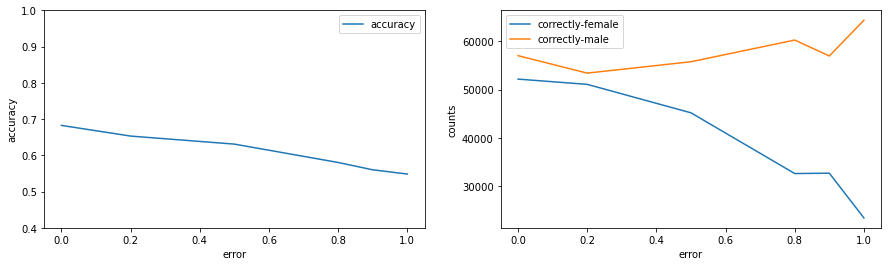

In [237]:
plot_df_mixture_gender = create_plot_df(mixture_gender_cfs, errors)
draw_plots(plot_df_mixture_gender)

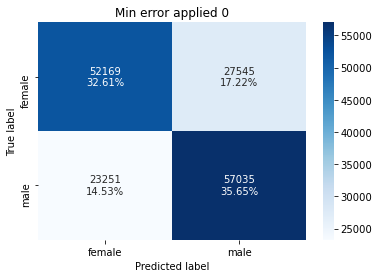

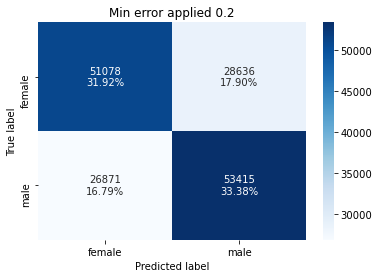

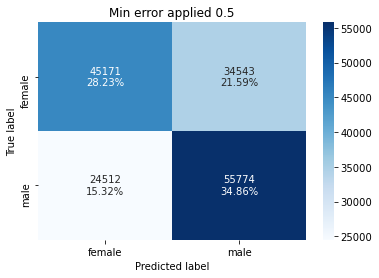

In [219]:
for index, cf in enumerate(mixture_gender_cfs):
    make_confusion_matrix(cf, categories=['female','male'], sum_stats = False, title='Min error applied {}'.format(errors[index]))